# Pipeline to Detect Lanes
---

## Calibrate Camera

This step needs to only be done once.

In [28]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image, HTML, display
from glob import glob
%matplotlib inline

# Lane finding functions to be imported
from lane_functions import chessboard_corners, find_reclanes, draw_box
from lane_functions import window_mask, detect_lanes, draw_lane
from lane_functions import find_poly_from_hist
from lane_functions import convert_curvature

## Determine the spatial mapping between image and truth

Perform camera calibration by identifying the locations of the chessboard corners. First step towards calibration.

### Parameters: 
- Checkerboard dimensions
  + This took me an especially long time to debug. It turns out, I had
    miscounted the number of corners for each of the checkerboards.
    The count in the original lab example had (8,5). In contrast, the
    checkerboards here have (9,6) corners. I should read directions more.
- Input file directory with images
  + This is found in `camera_cal/`.

In [2]:
# Parameters to find the chessboard corners. We have 9 columns and 6 rows, stored in "camera_cal"
checkcols = 9
checkrows = 6
imdir = 'camera_cal/'

# Find the object points and correspond with image points
objpoints, imgpoints = chessboard_corners( imdir, checkcols, checkrows )

# Visualize the images
imagesList=''.join( ["<img style='width: 150px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
                 for s in sorted(glob('examples/calibration_output/*.jpg')) ])
display(HTML(imagesList))

Image: camera_cal/calibration2.jpg calibration successful
Image: camera_cal/calibration3.jpg calibration successful
Calibration Unsuccessful for camera_cal/calibration4.jpg
Calibration Unsuccessful for camera_cal/calibration5.jpg
Image: camera_cal/calibration6.jpg calibration successful
Image: camera_cal/calibration7.jpg calibration successful
Image: camera_cal/calibration8.jpg calibration successful
Image: camera_cal/calibration9.jpg calibration successful
Image: camera_cal/calibration10.jpg calibration successful
Image: camera_cal/calibration11.jpg calibration successful
Image: camera_cal/calibration12.jpg calibration successful
Image: camera_cal/calibration13.jpg calibration successful
Image: camera_cal/calibration14.jpg calibration successful
Image: camera_cal/calibration15.jpg calibration successful
Image: camera_cal/calibration16.jpg calibration successful
Image: camera_cal/calibration17.jpg calibration successful
Image: camera_cal/calibration18.jpg calibration successful
Image: 

## Given the spatial correspondences, calibrate the cameras

Here, we determine the calibration and distortion parameters. We find these via `cv2.calibrateCamera` and store these in `mtx` and `dist`. Included is an example to undistort an image given `mtx` and `dist` by simply `calling cv2.undistort`.

Length Objects: 17, Image Points: 17
Image Size: (1280, 720)


Text(0.5,1,'Undistorted Image')

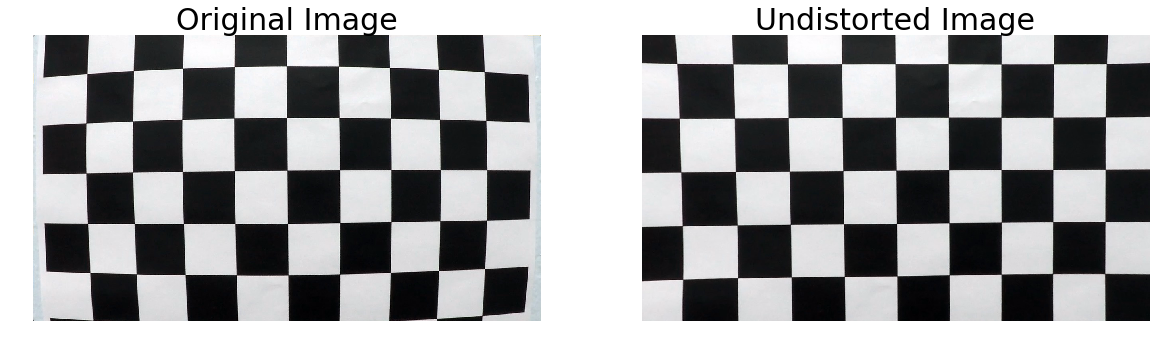

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
print('Length Objects: {}, Image Points: {}'.format(len(objpoints), len(imgpoints)))
print('Image Size: {}'.format(img_size))
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10)); 
ax1.axis('off'); ax2.axis('off')
ax1.imshow(img); plt.imsave('examples/distorted.jpg',img); 
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst); plt.imsave('examples/undistorted.jpg', dst); 
ax2.set_title('Undistorted Image', fontsize=30)

## Reprojection Parameters (Perspective)

Warp the image to an overhead perspective. To do this, again we need correspondences, which we set to be symmetrical about the center of the image for both the source and destination perspectives. The corners of a road are projected to upper and lower left and right corners of the new image perspective. The parameters to project are stored in `M` and the reprojection is `Minv`, the inverse of `M`.

(-0.5, 1279.5, 719.5, -0.5)

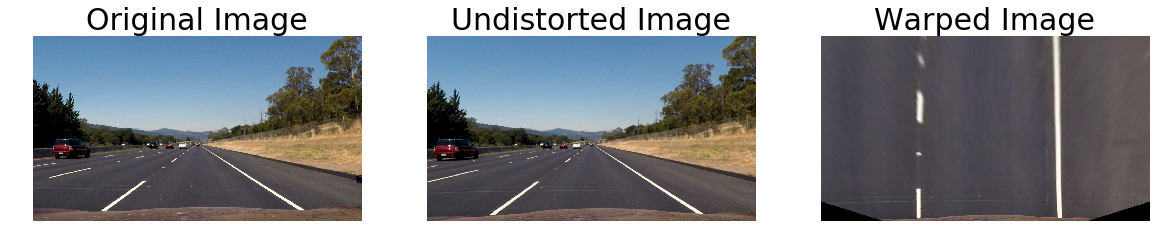

In [4]:
# Format is:
#    [ UpperLeft, LowerLeft, LowerRight, UpperRight ]
#    Assuming some symmetry, I added equal numbers left and right
src = np.float32(
     [[img_size[0] / 2 - 64, img_size[1] / 2 + 100],
      [img_size[0] / 6 - 10, img_size[1]],
      [img_size[0] * 5 / 6 + 10, img_size[1]],
      [img_size[0] / 2 + 64, img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4) + 50, 0],
     [(img_size[0] / 4) + 50, img_size[1]],
     [(img_size[0] * 3 / 4) - 50, img_size[1]],
     [(img_size[0] * 3 / 4) - 50, 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)

# Apply the transforms M and Minv to a test image
# img = cv2.imread('test_images/test2.jpg')
img = cv2.imread('test_images/straight_lines2.jpg')
calimg = cv2.undistort(img, mtx, dist, None, mtx)
warped = cv2.warpPerspective(calimg, M, img_size, flags=cv2.INTER_LINEAR)

# Display the image in the Jupyter notebook
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30); ax1.axis('off')
ax2.imshow(cv2.cvtColor(calimg, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30); ax2.axis('off')
ax3.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax3.set_title('Warped Image', fontsize=30); ax3.axis('off')

## Draw lines on the image

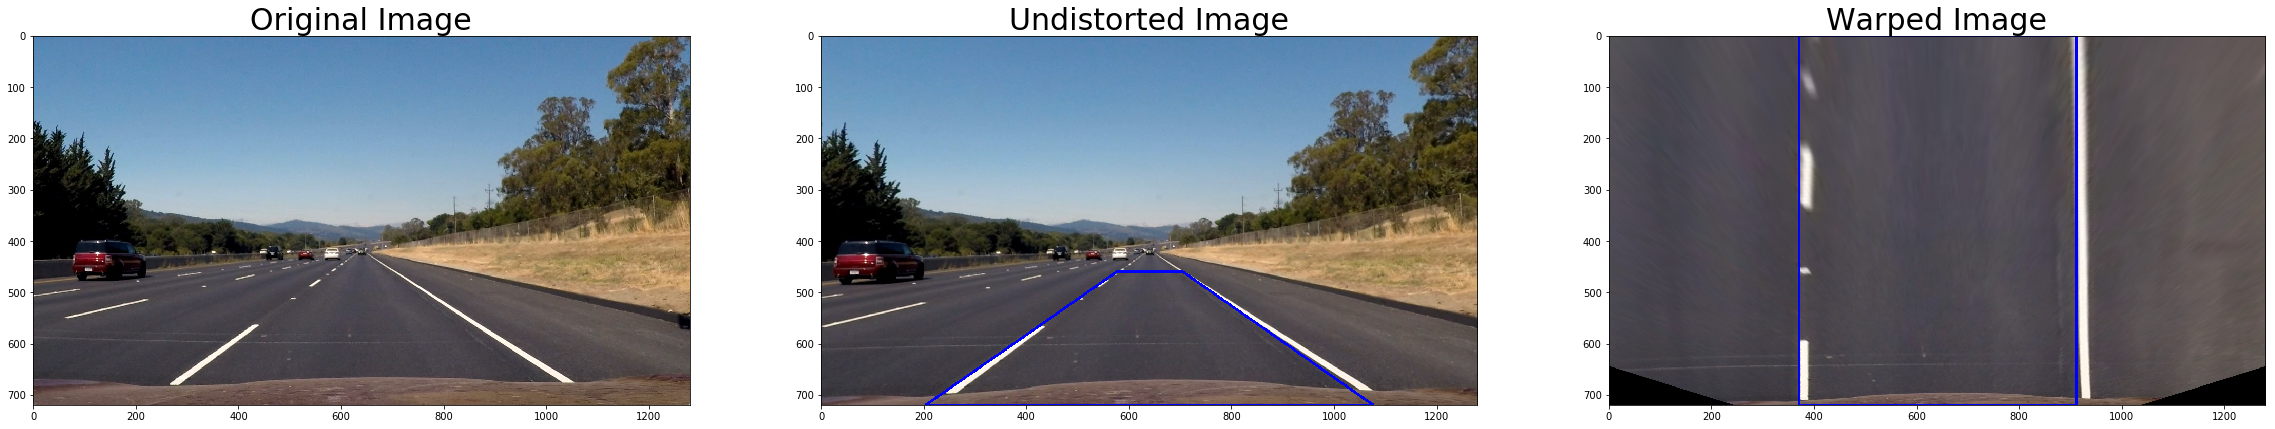

In [5]:
srcpairs = []; dstpairs = []
for pair in src:
    srcpairs += [tuple(pair.astype(int))]
for pair in dst:
    dstpairs += [tuple(pair.astype(int))]
    
fig = plt.figure(figsize=(40,40)); plt.axis('on'); fig.subplots(1,3)
ax1 = plt.subplot(1,3,1); ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30); 
ax2 = plt.subplot(1,3,2); draw_box(calimg, srcpairs)
ax2.set_title('Undistorted Image', fontsize=30); 
ax3 = plt.subplot(1,3,3); draw_box(warped, dstpairs)
ax3.set_title('Warped Image', fontsize=30); 

## Do some line detection from the overhead imagery

Binarize the image and then find the most relevant pixels by binarizing the image using thresholds.

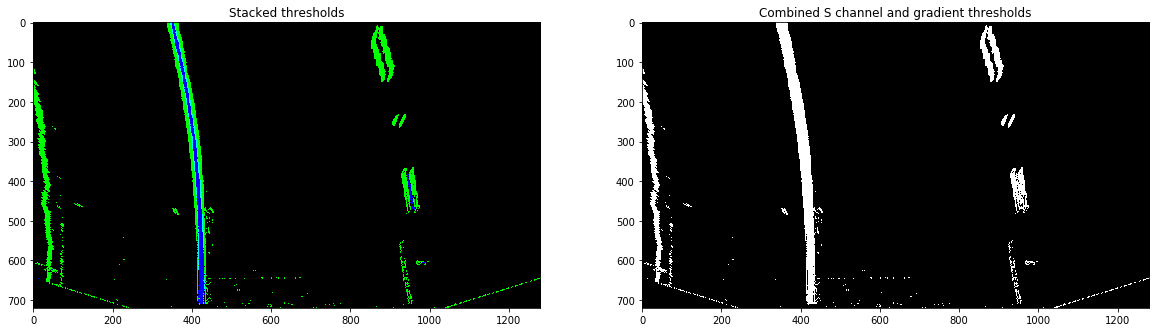

In [6]:
# Let's use a different image (one with a curve). Ignore this section, since we just wanted to change the image up.
img = cv2.imread('test_images/test2.jpg')
calimg = cv2.undistort(img, mtx, dist, None, mtx)
warped = cv2.warpPerspective(calimg, M, img_size, flags=cv2.INTER_LINEAR)

# Do line detection from a binarized image
color_binary, combined_binary = find_reclanes(warped)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

## Find the right and left lane lines

Find a single polynomial that fits the binarized pixel values on the image.

If this is done from scratch, it can be implemented with one of two functions:
- `find_poly_from_hist`: Fits a polynomial to a sliding window derived by histogram
- `find_poly_from_conv`: Uses convolution to determine the points in the sliding window

If this is done from a previous frame, the search window is set to the previous polynomial with:
- `find_poly_from_poly`: Fits a polynomial by checking the window of a previous polynomial

Once the polynomial coefficients are found, $\alpha$, $\beta$, and $\gamma$ in the polynomial function $x = \alpha y^2 + \beta^y + \gamma$, we can plot the lanes by using $x$ the fitted horizontal position and $y$ to be the vertical.

(720, 0)

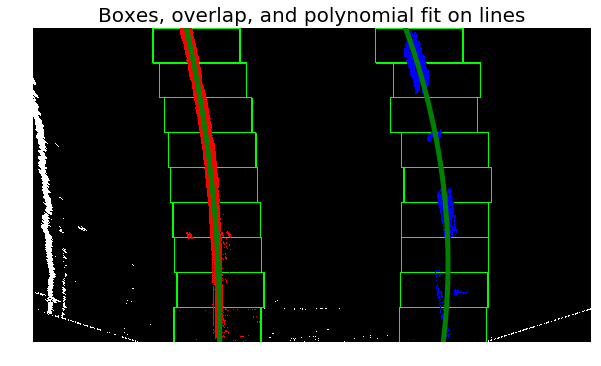

In [32]:
# Which method should we use?
#  - slide: sliding window
#  - conv: convolutional window
#  - poly: polynomial window
slide_conv_poly='slide'

# Determine the left and right polynomials
if slide_conv_poly == 'slide':
    # left_fit, right_fit = find_sliding_poly(combined_binary)
    lr_fit = find_poly_from_hist(combined_binary)
elif slide_conv_poly == 'conv':
    lr_fit = find_poly_from_hist(combined_binary)
elif slide_conv_poly == 'poly':
    lr_fit = find_poly_from_hist(combined_binary)

# The left and right polynomials
left_fit = lr_fit[0]
right_fit = lr_fit[1]

# Generate x and y values for plotting
ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot and overlay the image
plt.figure(figsize=(10,10)); plt.axis('off')
plt.title('Boxes, overlap, and polynomial fit on lines', fontsize=20)

out_img = lr_fit[4]
plt.imshow(out_img); 
plt.plot(left_fitx, ploty, color='green', linewidth=5)
plt.plot(right_fitx, ploty, color='green', linewidth=5)
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [66]:
%load_ext autoreload
%autoreload
print( convert_curvature(left_fitx, right_fitx, ploty) )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1024.5967858628649, 488.96302514528219)


## Reproject back and color the lane green

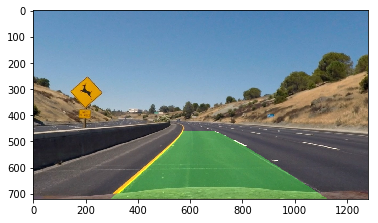

In [8]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)

# color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
color_warp = np.copy(warp_zero)

# # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

# Combine the result with the original image
result = cv2.addWeighted(calimg, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

## Combined method into a single function

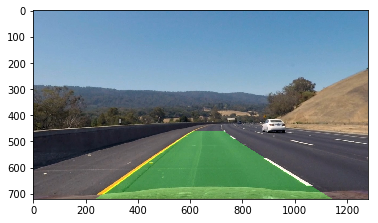

In [9]:
laneimage = detect_lanes('test_images/test3.jpg', mtx, dist, M, Minv)
plt.imshow(cv2.cvtColor(laneimage,cv2.COLOR_BGR2RGB))

## Use a class for persistence among frames

In [10]:
# Create a decorator function that will process a single frame with known calibration and warp parameters
def detect_lanes_video(img):
    return detect_lanes(img, mtx, dist, M, Minv)

In [11]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [12]:
from moviepy.editor import VideoFileClip

video_output1 = 'output_videos/challenge_video_output.mp4'
video_input1 = VideoFileClip('input_videos/challenge_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(detect_lanes_video)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_output.mp4
[MoviePy] Writing video output_videos/challenge_video_output.mp4


 10%|▉         | 47/485 [00:06<01:04,  6.77it/s]

KeyboardInterrupt: 

In [40]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
